In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

np.random.seed(3)
tf.random.set_seed(3)

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen =  ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_의자/train',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_의자/validation',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

test_generator = test_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_의자/test',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4, 
       class_mode='binary')

Found 404 images belonging to 2 classes.
Found 132 images belonging to 2 classes.
Found 132 images belonging to 2 classes.


In [3]:
from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# vgg16_model = VGG16(weights='imagenet', include_top=True)
# 학습이 더이상 되지 않도록 설정을 한다.
vgg16_model.trainable = False
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation 

# 학습 모델을 설정
model = Sequential()

# VGG 16 모델 설정
model.add(vgg16_model)

# 출력층 직전의 입력층
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
____________________________________

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=3) # 모니터 기준 설정 (val loss) 
                                                               # 10회 Epoch동안 개선되지 않는다면 종료
    


In [6]:
#-------------------------------------------------------------------------------------------------------
# 디렉토리 만드는 코드(방법)
import os # os가 import 되어야 만들 수 있음


MODEL_DIR = 'C:/Users/user/Desktop/최종데이터셋_6.23' # 현재 디렉토리에 모델이란 디렉토리를 하나 만든다.
if not os.path.exists(MODEL_DIR):# 만약 이런 디렉토리가 없다면 만들어라.
    os.mkdir(MODEL_DIR)
#-------------------------------------------------------------------------------------------------------    
# 모델 저장 방법
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss: .4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                              verbose = 1, save_best_only=True) 
# callback에 있는 모듈이므로 early stopping과 같이 불러와야 함.
# verbose: 화면에 찍어달라는 말
# 즉 가장 loss가 낮았던 최고의 모델을 지정된 경로에 저장하고 화면에 찍어라
#-------------------------------------------------------------------------------------------------------   


# datagen = ImageDataGenerator(
#     #rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest')

# datagen.fit(train_generator) # datagen 최신 모델은 반드시 .fit을 따로 해줘야 한다고 함.

In [8]:
#with tf.device('/gpu:0'):
history = model.fit_generator(train_generator, steps_per_epoch=101,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=33, callbacks=[earlystopping, checkpointer], verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
101/101 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.8837
Epoch 00001: val_loss improved from inf to 0.18736, saving model to C:/Users/user/Desktop\최종데이터셋_6.2301- 0.1874.hdf5
101/101 [==============================] - 36s 354ms/step - loss: 0.2629 - accuracy: 0.8837 - val_loss: 0.1874 - val_accuracy: 0.9091
Epoch 2/30
101/101 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9777
Epoch 00002: val_loss improved from 0.18736 to 0.08768, saving model to C:/Users/user/Desktop\최종데이터셋_6.2302- 0.0877.hdf5
101/101 [==============================] - 36s 355ms/step - loss: 0.0629 - accuracy: 0.9777 - val_loss: 0.0877 - val_accuracy: 0.9621
Epoch 3/30
101/101 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9975
Epoch 00003: val_loss did not improve from 0.08768
101/101 [==============================] - 36s 357ms/step - loss: 0.0212 - accu

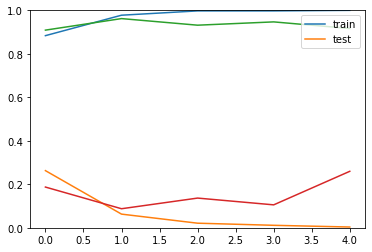

In [31]:
# 오차 정도와 정확도를 그래프로 그린다.
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# plt.plot(epochs, acc, 'bo', label='Train acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# #plt.title('Training and validation accuracy')
# #plt.legend()

# plt.figure()

# #plt.plot(epochs, loss, 'bo', label='Training loss')
# #plt.plot(epochs, val_loss, 'b', label='Validation loss')
# #plt.title('Training and validation loss')
# #plt.legend()

# plt.show()

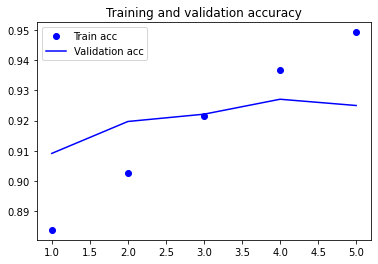

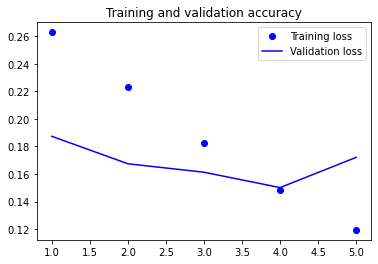

In [12]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Train acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# 저장한 모델 사용

In [20]:
from tensorflow.keras.models import load_model
del model # 위에 선언한 모델이 있을 수 있으니 모델이라는 것을 일단 지움

model = load_model('C:/Users/user/Desktop/최종데이터셋_6.2302- 0.0877.hdf5')
# model = load_model('13- 0.0340.hdf5')  #working directory에 있으면 바로 출력 가능

test_loss, test_acc = model.evaluate(test_generator, steps=11)
print('test acc:', test_acc)

11/11 [==============================] - 3s 260ms/step - loss: 0.1254 - accuracy: 0.9545
test acc: 0.9545454382896423


# [서랍장]

Found 260 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______

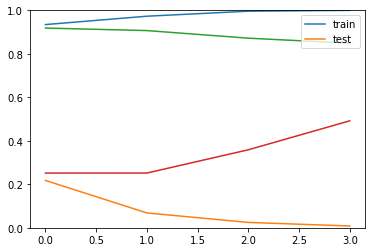

In [35]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

np.random.seed(3)
tf.random.set_seed(3)

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen =  ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_서랍장/train',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_서랍장/validation',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

test_generator = test_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_서랍장/test',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4, 
       class_mode='binary')

from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# vgg16_model = VGG16(weights='imagenet', include_top=True)
# 학습이 더이상 되지 않도록 설정을 한다.
vgg16_model.trainable = False
vgg16_model.summary()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation 

# 학습 모델을 설정
model = Sequential()
# VGG 16 모델 설정
model.add(vgg16_model)

# 출력층 직전의 입력층
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=3) # 모니터 기준 설정 (val loss) 
                                                               # 10회 Epoch동안 개선되지 않는다면 종료
    
#-------------------------------------------------------------------------------------------------------
# 디렉토리 만드는 코드(방법)
import os # os가 import 되어야 만들 수 있음


MODEL_DIR = 'C:/Users/user/Desktop/최종데이터셋_서랍장' # 현재 디렉토리에 모델이란 디렉토리를 하나 만든다.
if not os.path.exists(MODEL_DIR):# 만약 이런 디렉토리가 없다면 만들어라.
    os.mkdir(MODEL_DIR)
#-------------------------------------------------------------------------------------------------------    
# 모델 저장 방법
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss: .4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                              verbose = 1, save_best_only=True) 
# callback에 있는 모듈이므로 early stopping과 같이 불러와야 함.
# verbose: 화면에 찍어달라는 말
# 즉 가장 loss가 낮았던 최고의 모델을 지정된 경로에 저장하고 화면에 찍어라
#-------------------------------------------------------------------------------------------------------   

history = model.fit_generator(train_generator, steps_per_epoch=65,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=22, callbacks=[earlystopping, checkpointer], verbose=1)

# 오차 정도와 정확도를 그래프로 그린다.
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [40]:
from tensorflow.keras.models import load_model
del model # 위에 선언한 모델이 있을 수 있으니 모델이라는 것을 일단 지움

model = load_model('C:/Users/user/Desktop/최종데이터셋_서랍장/최종데이터셋_서랍장01- 0.2517.hdf5')
# model = load_model('13- 0.0340.hdf5')  #working directory에 있으면 바로 출력 가능

test_loss, test_acc = model.evaluate(test_generator, steps=22)
print('test acc:', test_acc)

22/22 [==============================] - 5s 244ms/step - loss: 0.0765 - accuracy: 0.9884
test acc: 0.9883720874786377


# [책상]

Found 274 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 94 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______

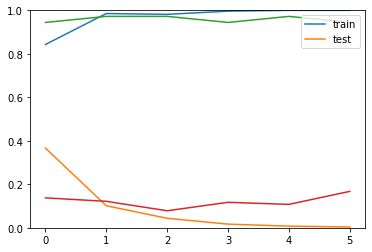

In [41]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

np.random.seed(3)
tf.random.set_seed(3)

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen =  ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_책상/train',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_책상/validation',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

test_generator = test_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_책상/test',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4, 
       class_mode='binary')

from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# vgg16_model = VGG16(weights='imagenet', include_top=True)
# 학습이 더이상 되지 않도록 설정을 한다.
vgg16_model.trainable = False
vgg16_model.summary()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation 

# 학습 모델을 설정
model = Sequential()
# VGG 16 모델 설정
model.add(vgg16_model)

# 출력층 직전의 입력층
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=3) # 모니터 기준 설정 (val loss) 
                                                               # 10회 Epoch동안 개선되지 않는다면 종료
    
#-------------------------------------------------------------------------------------------------------
# 디렉토리 만드는 코드(방법)
import os # os가 import 되어야 만들 수 있음


MODEL_DIR = 'C:/Users/user/Desktop/최종데이터셋_책상' # 현재 디렉토리에 모델이란 디렉토리를 하나 만든다.
if not os.path.exists(MODEL_DIR):# 만약 이런 디렉토리가 없다면 만들어라.
    os.mkdir(MODEL_DIR)
#-------------------------------------------------------------------------------------------------------    
# 모델 저장 방법
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss: .4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                              verbose = 1, save_best_only=True) 
# callback에 있는 모듈이므로 early stopping과 같이 불러와야 함.
# verbose: 화면에 찍어달라는 말
# 즉 가장 loss가 낮았던 최고의 모델을 지정된 경로에 저장하고 화면에 찍어라
#-------------------------------------------------------------------------------------------------------   

history = model.fit_generator(train_generator, steps_per_epoch=69,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=9, callbacks=[earlystopping, checkpointer], verbose=1)

# 오차 정도와 정확도를 그래프로 그린다.
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [48]:
from tensorflow.keras.models import load_model
del model # 위에 선언한 모델이 있을 수 있으니 모델이라는 것을 일단 지움

model = load_model('C:/Users/user/Desktop/최종데이터셋_책상02- 0.1218.hdf5')
# model = load_model('13- 0.0340.hdf5')  #working directory에 있으면 바로 출력 가능

test_loss, test_acc = model.evaluate(test_generator, steps=9)
print('test acc:', test_acc)

9/9 [==============================] - 2s 255ms/step - loss: 0.3210 - accuracy: 0.8611
test acc: 0.8611111044883728


# [침대]

Found 97 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_______

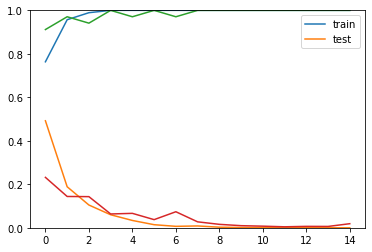

In [49]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

np.random.seed(3)
tf.random.set_seed(3)

train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen =  ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_침대/train',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_침대/validation',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4,
       class_mode='binary')

test_generator = test_datagen.flow_from_directory(
       'C:/Users/user/Desktop/최종데이터셋_침대/test',   #학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=4, 
       class_mode='binary')

from tensorflow.keras.applications import VGG16
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# vgg16_model = VGG16(weights='imagenet', include_top=True)
# 학습이 더이상 되지 않도록 설정을 한다.
vgg16_model.trainable = False
vgg16_model.summary()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation 

# 학습 모델을 설정
model = Sequential()
# VGG 16 모델 설정
model.add(vgg16_model)

# 출력층 직전의 입력층
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])
model.summary()

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystopping = EarlyStopping(monitor='val_loss', patience=3) # 모니터 기준 설정 (val loss) 
                                                               # 10회 Epoch동안 개선되지 않는다면 종료
    
#-------------------------------------------------------------------------------------------------------
# 디렉토리 만드는 코드(방법)
import os # os가 import 되어야 만들 수 있음


MODEL_DIR = 'C:/Users/user/Desktop/최종데이터셋_침대' # 현재 디렉토리에 모델이란 디렉토리를 하나 만든다.
if not os.path.exists(MODEL_DIR):# 만약 이런 디렉토리가 없다면 만들어라.
    os.mkdir(MODEL_DIR)
#-------------------------------------------------------------------------------------------------------    
# 모델 저장 방법
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss: .4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                              verbose = 1, save_best_only=True) 
# callback에 있는 모듈이므로 early stopping과 같이 불러와야 함.
# verbose: 화면에 찍어달라는 말
# 즉 가장 loss가 낮았던 최고의 모델을 지정된 경로에 저장하고 화면에 찍어라
#-------------------------------------------------------------------------------------------------------   

history = model.fit_generator(train_generator, steps_per_epoch=24,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=9, callbacks=[earlystopping, checkpointer], verbose=1)

# 오차 정도와 정확도를 그래프로 그린다.
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [56]:
from tensorflow.keras.models import load_model
del model # 위에 선언한 모델이 있을 수 있으니 모델이라는 것을 일단 지움

model = load_model('C:/Users/user/Desktop/최종데이터셋_침대08- 0.0274.hdf5')
# model = load_model('13- 0.0340.hdf5')  #working directory에 있으면 바로 출력 가능

test_loss, test_acc = model.evaluate(test_generator, steps=9)
print('test acc:', test_acc)

9/9 [==============================] - 2s 210ms/step - loss: 0.0342 - accuracy: 0.9706
test acc: 0.970588207244873


# 이미지 다양성을 위한 흑백

In [ ]:
# 이미지를 흑백으로 변환
def rgb2gray(img): # gray로 색을 바꿈
    return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    
x_train = rgb2gray(x_train).reshape(x_train.shape[0], 32, 32, 1).astype('float32') /255
x_test = rgb2gray(x_test).reshape(x_test.shape[0], 32, 32, 1).astype('float32') /255

# 데이터 증강

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3), 
                 activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(data) # datagen 최신 모델은 반드시 .fit을 따로 해줘야 한다고 함.

model.fit(datagen.flow(x_train, y_train, batch_size=16, # batch_size가 16이면 증폭 개수는 train 데이터수 * batch(16)가 총 증폭개수이다.
         subset='training'),
         validation_data=datagen.flow(x_train, y_train,
         batch_size=8, subset='validation'), # batch_sie
         steps_per_epoch=len(x_train) / 32, epochs=epochs)

# data augmentation을 굉장히 많이 생성해서 해도 모델의 성능이 성장하지 않는다.
# data augmentation 적용의 이점은 모델이 training시 충분한 데이터의 다양성을 학습하지 못해 test loss가 train loss와 현저하게
# 차이나는 문제를 방지하기 위해 모델이 충분한 데이터의 다양성을 학습할 수 있게 하기


'''
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(x_train) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
'''

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
#loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.figure()

#plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.title('Training and validation loss')
#plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
        smooth_curve(acc), 'bo', label='Train acc')
plt.plot(epochs,
        smooth_curve(val_acc), 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.figure()

#plt.plot(epochs,
        #smooth_curve(loss), 'bo', label='Training loss')
#plt.plot(epochs,
        #smooth_curve(val_loss), 'b', label='Validation loss')
#plt.title('Training and validation accuracy')
#plt.legend()

plt.show()

# CNN

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D
from tensorflow.keras.models import Sequential

In [7]:
model = Sequential()
model.add(Conv2D())
model.add(MaxPooling2D())
model.add(conv2D())
model.add(MaxPooling2D())
model.add(Dense())
model.add(Dense())

model.compile(optimizer = , )

TypeError: __init__() missing 2 required positional arguments: 'filters' and 'kernel_size'